Exercise 2: Bayesian computation with Stan and Farmer Jöns
============
### *Rasmus Bååth (adapted for Python by Christophe Carvenius)*
Here follows a number of data analytic questions. Use [Stan](http://mc-stan.org/) and R to build models that probe these questions. The Stan documentation can be found here: http://mc-stan.org/documentation/ . You can find the answers to the exercise questions here: http://rpubs.com/rasmusab/answers_bayes_with_farmer_jons

## 1. Getting started
Below is a code scaffold you can use. Right now the scaffold contains a simple model for two binomial rates, but this should be replaced with a model that matches the relevant questions.

**→ Read through the code to see if you can figure out what does what and then run it to make sure it works. It should print out some statistics and some pretty graphs.**

 

In [ ]:
# Import libraries
import pystan # install with pip install pystan
import pandas as pd
import numpy as np

# The Stan model as a string.
model_string = """
data {
  # Number of data points
  int n1;
  int n2;
  # Number of successes
  int y1[n1];
  int y2[n2];
}

parameters {
  real<lower=0, upper=1> theta1;
  real<lower=0, upper=1> theta2;
}

model {  
  theta1 ~ beta(1, 1);
  theta2 ~ beta(1, 1);
  y1 ~ bernoulli(theta1);
  y2 ~ bernoulli(theta2); 
}

generated quantities {
}
"""

y1 = [0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
y2 = [0, 0, 1, 1, 1, 0, 1, 1, 1, 0]
data_list = {'y1' : y1, 'y2' : y2, 'n1' : len(y1), 'n2' : len(y2)}

# Compiling and producing posterior samples from the model.
stan_samples = pystan.stan(model_code = model_string, data = data_list)

# Plotting and summarizing the posterior distribution
print(stan_samples)
stan_samples.plot()

**Hint 1:** `bernoulli` is the Bernoulli distribution which is the special case of the binomial distribution when there is just one trial `(bernoulli(x) === binomial(1, x))`. That is, if the data is coded as 4 successes out of 6 `(x = 4; n = 6)` it would be most convenient to use a binomial distribution. If the data is coded like `[1, 1, 1, 1, 0, 0]` it would be more convenient to use a Bernoulli distribution. The result would in any case be the same.

**Hint 2:** Stan has quite a lot of different built in data types and two that sounds the same, but aren’t, are vectors and arrays. Vectors are simple, they are lists of real numbers and `vector[4] v;` would define a vector or length 4. Arrays are more general in that they can contain other data types, for example `int a[4]` would define an array of integers of length 4. Note the different placement of the `[]`-brackets compared to defining a vector.

**Hint 3:** When defining parameters it’s important to properly define the *support*, that is, for what values the parameter has a defined meaning. For example, the support of a mean is on the whole real line (-Inf to Inf) so that can simply be declared by `real mu;`. A *standard deviation*, on the other hand, can’t be below 0.0, which could be written like this: `real<lower=0> sigma`. Finaly, a rate has to be between 0 and 1 which would be written like `real<lower=0, upper=1> theta;`.

## 2. Manipulating samples
To inspect and manipulate samples from individual parameters it is useful to convert the Stan “object” into a simple dataframe which gets one column per parameter: 

In [13]:
s = pd.DataFrame(stan_samples.extract())
s.head()
 

,theta1,theta2,lp__
0,0.338945,0.673828,-15.336131
1,0.125290,0.825161,-17.500812
2,0.110733,0.596067,-15.812474
3,0.536350,0.324687,-18.623693
4,0.174577,0.282452,-17.472201


This is useful as you can, for example, plot and compare the individual parameters.

In [23]:
# The probability that the rate theta1 is smaller than theta2
np.mean(s.theta1 < s.theta2) # Can also be written as sum(s.theta1 < s.theta2) / len(s)

0.96499999999999997

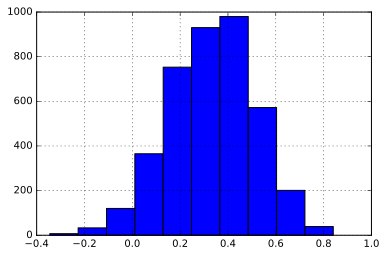

In [25]:
# Plotting distribution of the difference between theta1 and theta2
(s.theta2 - s.theta1).hist()

**→ Calculate the probability that the difference between the two underlying rates is smaller than 0.2.**

*Hint:* `abs(x - y)` calculates the absolute difference between x and y.

## 3. Cows and disease

Farmer Jöns has a huge number of cows. Earlier this year he ran an experiment where he gave 10 cows medicine A and 10 medicine B and then measured whether they got sick `0` or not `1` during the summer season. Here is the resulting data:

In [28]:
cowA = [0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
cowB = [0, 0, 1, 1, 1, 0, 1, 1, 1, 0]

**→ Jöns now wants to know: How effective are the drugs? What is the evidence that medicine A is better or worse than medicine B?**

## 4. Cows and milk
Farmer Jöns has a huge number of cows. Earlier this year he ran an experiment where he gave 10 cows a special diet that he had heard could make them produce more milk. He recorded the number of liters of milk from these “diet” cows and from 15 “normal” cows during one month. This is the data:

In [31]:
diet_milk = [651, 679, 374, 601, 401, 609, 767, 709, 704, 679]
normal_milk = [798, 1139, 529, 609, 553, 743, 151, 544, 488, 555, 257, 692, 678, 675, 538]

**→ Jöns now wants to know: Was the diet any good, does it results in better milk production?**

**Hint 1:** To model this you might find it useful to use the Normal distribution which is called `normal` in Stan. A statement using `normal` could look like:
 
```for(i in 1:n ) {
  y[i] ~ normal(mu, sigma)
}```

Where `mu` is the mean and `sigma` is the standard deviation and `y` is a vector of length `n`. Since Stan is partly vectorized the above could also be written without the loop like `y ~ normal(mu, sigma)`.

**Hint 2:** You will have to put priors on `mu` and `sigma` and here there are many options. A lazy but often OK shortcut is to just use `uniform` distributions that are wide enough to include all thinkable values of the parameters. If you want to be extra sloppy you can actually skip putting any priors at all in which case Stan will use uniform(-Infinity, Infinity), but it’s good style to use explicit priors.

## Bonus questions 
If you have made it this far, great! Below are a couple of bonus questions. How far can you reach?
## 5. Cows and Mutant Cows
Farmer Jöns has a huge number of cows. Due to a recent radioactive leak in a nearby power plant he fears that some of them have become mutant cows. Jöns is interested in measuring the effectiveness of a diet on normal cows, but not on mutant cows (that might produce excessive amounts of milk, or nearly no milk at all!). The following data set contains the amount of milk for cows on a diet and cows on normal diet:

In [33]:
diet_milk = [651, 679, 374, 601, 4000, 401, 609, 767, 3890, 704, 679]
normal_milk = [798, 1139, 529, 609, 553, 743, 3, 151, 544, 488, 15, 257, 692, 678, 675, 538]

Some of the data points might come from mutant cows (also known as outliers).

**→ Jöns now wants to know: Was the diet any good, does it results in better milk production for non-mutant cows?**

**Hint:** Basically we have an outlier problem. A conventional trick in this situation is to supplement the normal distribution for a distribution with wider tails that is more sensitive to the central values and disregards the far away values (this is a little bit like trimming away some amount of the data on the left and on the right). A good choice for such a distribution is the t-distribution which is like the normal but with a third parameter called the “degrees of freedom”. The lower the “degrees of freedom” the wider the tails and when this parameter is larger than about 50 the t-distribution is practically the same as the normal. A good choice for the problem with the mutant cows would be to use a t distribution with around 3 degrees of freedom:

`y ~ student_t(3, mu, sigma);`

Of course, you could also estimate the “degrees of freedom” as a free parameter, but that might be overkill in this case…

## 6. Chickens and diet
Farmer Jöns has a huge number of cows. He also has chickens. He tries different diets on them too with the hope that they will produce more eggs. Below is the number of eggs produced in one week by chickens on a diet and chickens eating normal chicken stuff:

In [34]:
diet_eggs = [6, 4, 2, 3, 4, 3, 0, 4, 0, 6, 3]
normal_eggs = [4, 2, 1, 1, 2, 1, 2, 1, 3, 2, 1]

**→ Jöns now wants to know: Was the diet any good, does it result in the chickens producing more eggs?**

**Hint:** The `poisson` distribution is a discrete distribution that is often a reasonable choice when one wants to model count data (like, for example, counts of eggs). The `poisson` has one parameter `λλ` which stands for the mean count. In Stan you would use the Poisson like this:

`y ~ poisson(lambda);`

where y would be a single integer or an integer array of length n ( defined like int y[n];) and lambda a real number bounded at 0.0 (`real<lower=0> lambda;`)

## 7. Cows and milk in a different data format
It's often common to have all data in a data frame. Inspect the following data frame d:

In [42]:
d = pd.DataFrame({'milk' : [651, 679, 374, 601, 401, 609, 767, 709, 704, 679, 798, 1139,
                            529, 609, 553, 743, 151, 544, 488, 555, 257, 692, 678, 675, 538],
                 'group' : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 
                            2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]})

Looking at `d` you should see that it contains the same data as in exercise (4) but coded with one cow per row (The mutant cows were perhaps just a dream…). The diet group is coded as a 1 and the normal group is coded as a 2. This data could be read into Stan by using the following data list:

In [47]:
data_list = dict(y = d.milk, x = d.group, n = len(d.milk), 
                  n_groups = max(d.group))

**→ Modify the model from (4) to work with this data format instead.**

**Hint:** In your Stan code you can loop over the group variable and use it to pick out the parameters belonging to that group like this:

```for(i in 1:n) {
  y[i] ~ normal( mu[x[i]], sigma[x[i]] ) 
}```

Where `mu` and `sigma` now are 2-length vectors. This is also known as indexception: You use an index (`i`) to pick out an index (`x[i]`) to pick out a value (`mu[x[i]]`). As indexing is vectorised in Stan this can actually be shortened to just:

`y ~ normal( mu[x], sigma[x] );`

## 8. Cows and more diets
Farmer Jöns has a huge number of cows. He also has a huge number of different diets he wants to try. In addition to the diet he already tried, he tries another diet (let’s call it diet 2) on 10 more cows. Copy-n-paste the following into R and inspect the resulting data frame `d`.

In [49]:
d = pd.DataFrame({'milk' : [651, 679, 374, 601, 401, 609, 767, 709, 704, 679, 798, 1139, 529,
                            609, 553, 743, 151, 544, 488, 555, 257, 692, 678, 675, 538, 1061,
                            721, 595, 784, 877, 562, 800, 684, 741, 516],
                  'group' : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                             2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]})

It contains the same data as in the last exercise but with 10 added rows for diet 2 which is coded as group = 3.

**→ Now Jöns now wants to know: Which diet seems best, if any? How much more milk should he be expecting to produce using the best diet compared to the others?**

**Hint:** If you looped or used vectorization in a smart way you should be able to use the same model as in Question 7.

## 9. Cows and sunshine
Farmer Jöns has a huge number of cows. He is wondering whether the amount of time a cow spends outside in the sunshine affects how much milk she produces. To test this he makes a controlled experiment where he picks out 20 cows and assigns each a number of hours she should spend outside each day. The experiment runs for a month and Jöns records the number of liters of milk each cow produces. Copy-n-paste the following into R and inspect the resulting data frame `d`.

In [50]:
d = pd.DataFrame({'milk' : [685, 691, 476, 1151, 879, 725, 1190, 1107, 809, 539,
                            298, 805, 820, 498, 1026, 1217, 1177, 684, 1061, 834],
                 'hours' : [3, 7, 6, 10, 6, 5, 10, 11, 9, 3, 6, 6, 3, 5, 8, 11, 
                            12, 9, 5, 5]})

**→ Using this data on hours of sunshine and resulting liters of milk Jöns wants to know: Does sunshine affect milk production positively or negatively?**

**Hint 1:** A model probing the question above requires quite small changes to the model you developed in Question 8.

**Hint 2:** You do remember the equation for the (linear regression) line? If not, here it is: `mu <- beta0 + beta1 * x;`
